# **Load libraries**

In [2]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.2 MB/s eta 0:00:00


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from category_encoders import TargetEncoder

In [4]:
sns.set_palette('viridis')
sns.color_palette(palette='viridis')

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

# **Load Dataset**

In [5]:
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "neuromusic/avocado-prices",
  "avocado.csv"
)

Using Colab cache for faster access to the 'avocado-prices' dataset.


# **Analyse and Preprocess Dataset**

Some relevant columns in the dataset:

*   Date - The date of the observation
*   AveragePrice - the average price of a single avocado
type - conventional or organic
*   year - the year
*   Region - the city or region of the observation
*   Total Volume - Total number of avocados sold
*   4046 - Total number of avocados with PLU 4046 sold
*   4225 - Total number of avocados with PLU 4225 sold
*   4770 - Total number of avocados with PLU 4770 sold

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [7]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


# Preprocess Dataset 1

As we will use classifier, I will take type as a target for classification.

In [8]:
df['type'] = df['type'].map({'conventional': 0, 'organic': 1})
df.dropna(inplace=True)

df_corr = df

We'll target encode the data, which will replace the categorical values with the mean target value of that category, as it provides a more continuous representation of the categorical data and can help capture the relationship between the categorical feature and the target variable.

In [10]:
encoder = TargetEncoder(cols=['region'])
df_corr = encoder.fit_transform(X=df_corr, y=df_corr['type'])

*Some encoding(Who knows, maybe the price is affected by the region?)*

In [11]:
df_corr.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,0,2015,0.5
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,0,2015,0.5
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,0,2015,0.5
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,0,2015,0.5
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,0,2015,0.5


In [12]:
df_corr.describe()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
count,18249,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000,18249.000000,18249.000000
mean,2016-08-13 23:30:43.498273792,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,0.499918,2016.147899,0.499918
min,2015-01-04 00:00:00,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,2015.000000,0.495522
25%,2015-10-25 00:00:00,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,0.000000,2015.000000,0.500000
50%,2016-08-14 00:00:00,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,0.000000,2016.000000,0.500000
75%,2017-06-04 00:00:00,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,1.000000,2017.000000,0.500000
max,2018-03-25 00:00:00,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,1.000000,2018.000000,0.500000
std,NaN,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.500014,0.939938,0.000601


In [13]:
df_corr['type'].value_counts()

,count
type,
0,9126
1,9123


'type' column is not skew, it is ok.

# **Choosing features**

In [14]:
corr = pd.DataFrame(np.abs(df_corr.corr())).sort_values('type', ascending=False)['type']

corr

,type
type,1.000000
AveragePrice,0.615845
Total Volume,0.232434
4225,0.232289
4046,0.225819
Small Bags,0.220535
Total Bags,0.217788
4770,0.210027
Large Bags,0.193177
XLarge Bags,0.175483


Top by abs. corr. are: AveragePrice and Total Volume.

In [15]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  int64         
 11  year          18249 non-null  int64         
 12  region        18249 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(2)
memory usage: 1.8 MB


# **Decision Boundary Graph**

Our target is type - either conventional or organic. For classifying each avocado we'll use RandomForestRegressor.

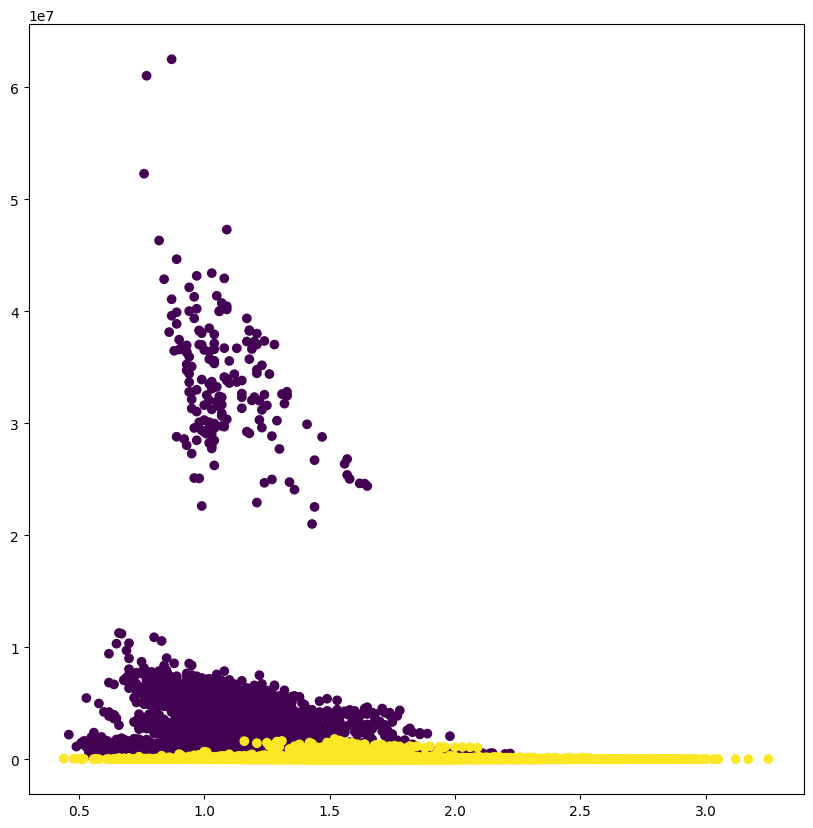

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(x="AveragePrice", y="Total Volume", c=df_corr['type'], data=df_corr)
plt.show()

In [17]:
df_corr = df_corr[df_corr['Total Volume'] < 5e7]

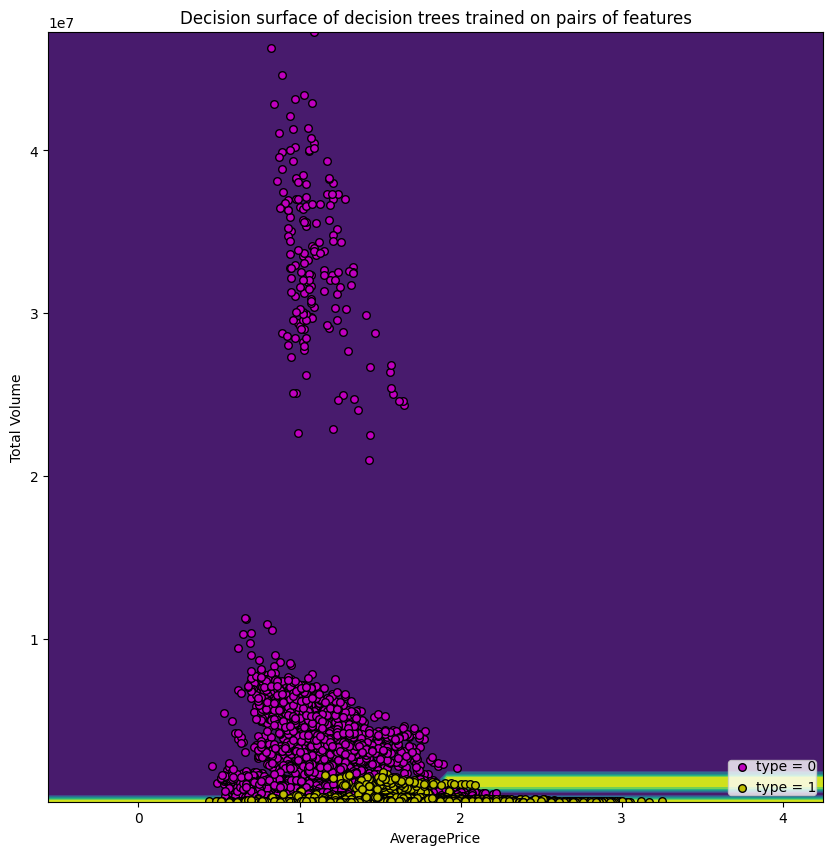

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

n_classes = df['type'].nunique()
plot_colors = "myg"
plot_step = 0.02

X = df_corr[['AveragePrice', 'Total Volume']]
y = df_corr['type']

# Train
clf = RandomForestClassifier().fit(X, y)

# Plot the decision boundary
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    ax=ax,
    cmap='viridis',
    response_method="predict",
    xlabel='AveragePrice',
    ylabel='Total Volume',
)

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = (y == i)

    plt.scatter(
        X.loc[idx, 'AveragePrice'],
        X.loc[idx, 'Total Volume'],
        c=color,
        label=f"type = {i}",
        edgecolor="black",
        s=30,
    )


plt.title("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.show()

In comparison with a single DT, the yellow area is sligthly larger, capturing better the pattern of the data.

# Split Dataset 2

Why one more time?

This time we are going to predict the AveragePrice of Avocados(are they really that costly?). For that purpose, we'll train and test RandomForestRegressor.

In [20]:
df['type'].unique()

array([0, 1])

In [9]:
X = df.drop(['AveragePrice', 'Date'], axis=1)
y = df['AveragePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
encoder = TargetEncoder(cols=['region'])

encoder.fit(X=X_train, y=y_train)

X_train = encoder.transform(X=X_train, y=y_train)
X_test = encoder.transform(X=X_test, y=y_test)

# **Hyperparameters**

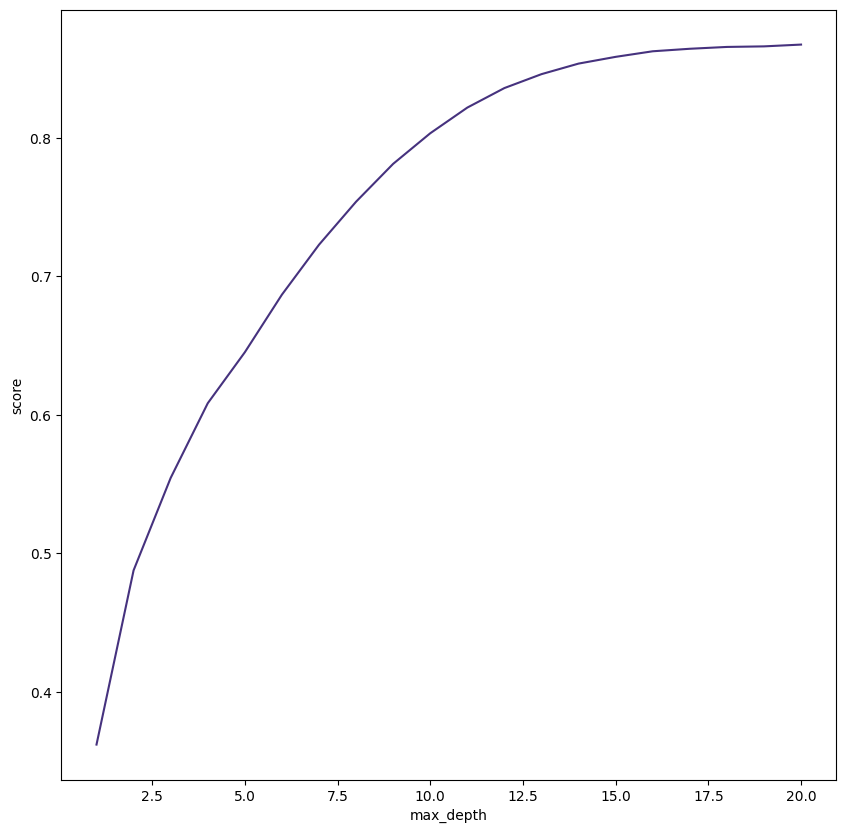

In [23]:
plt.figure(figsize=(10,10))

x_vals = range(1, 21)
y_vals = []

for i in x_vals:
  rgr = RandomForestRegressor(max_depth=i, random_state=42)
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('max_depth')
plt.ylabel('score')
plt.show()

In [24]:
x_vals[y_vals.index(max(y_vals))]

20

It shows that the accuracy of the predictions is increasing as the max depth of the tree is increasing.

I'll take 13, because otherwise it is already overfitting.

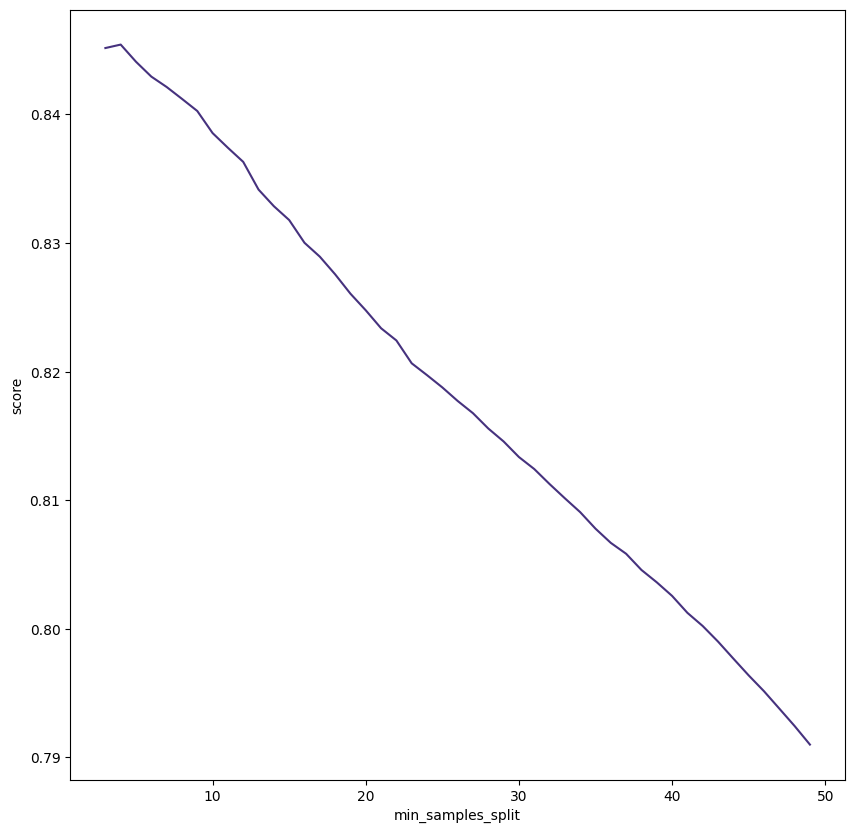

In [43]:
plt.figure(figsize=(10,10))

x_vals = range(3, 50)
y_vals = []

for i in x_vals:
  rgr = RandomForestRegressor(
      max_depth=13,
      min_samples_split=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.show()

In [45]:
x_vals[y_vals.index(max(y_vals[15:]))]

18

The min_samples_split shows how many samples should be there so that it can be split (questioned). 4 samples are too few(overfitting), so I'll take something more but stil quite good => 18.

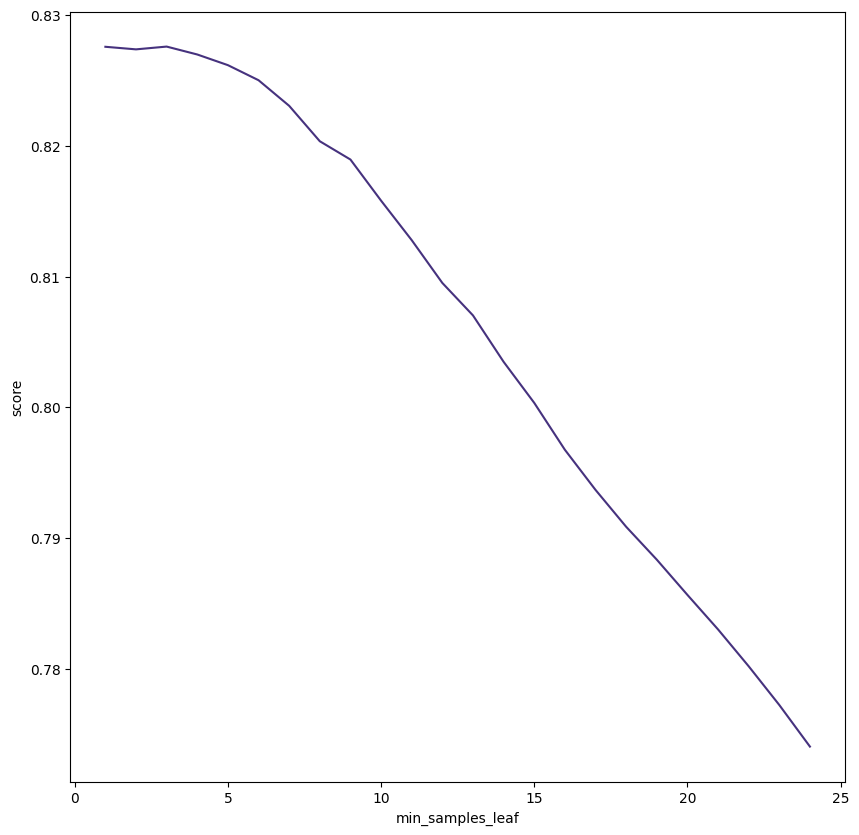

In [46]:
plt.figure(figsize=(10,10))

x_vals = range(1, 25)
y_vals = []

for i in x_vals:
  rgr = RandomForestRegressor(
      max_depth=13,
      min_samples_split=18,
      min_samples_leaf=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.show()

In [50]:
x_vals[y_vals.index(max(y_vals))]

3

The min_samples_leaf shows how many samples should be there so it can become a leaf. The best is 3, but it is overfitting(for a tiny group of samples there would be a leaf), so I'll take 10.

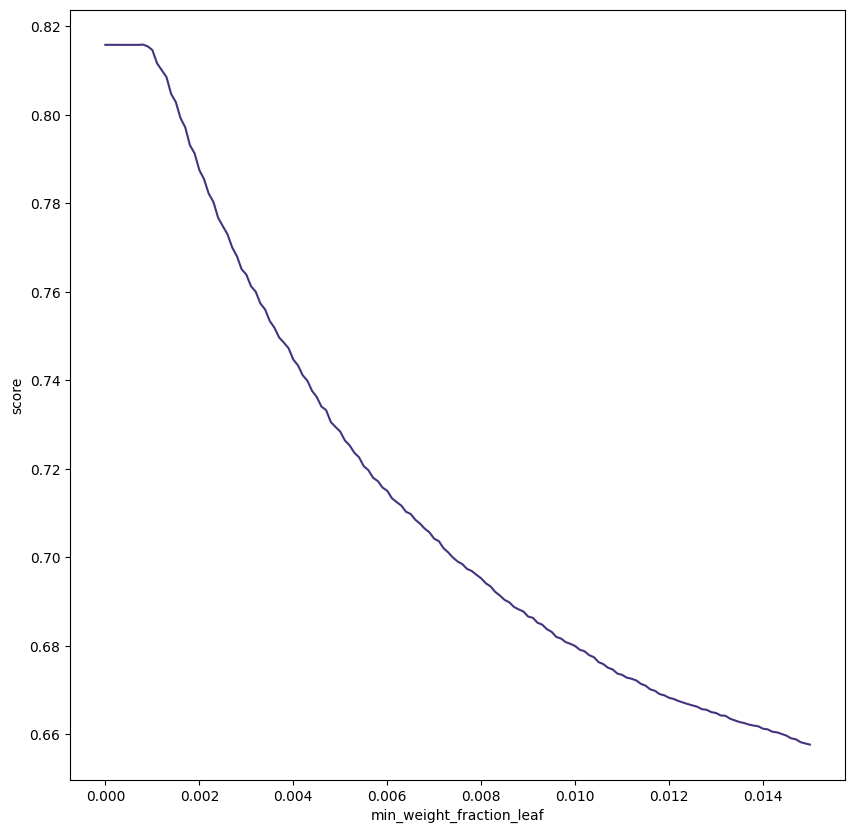

In [51]:
plt.figure(figsize=(10,10))

x_vals = [i * 0.0001 for i in range(151)]
y_vals = []

for i in x_vals:
  rgr = RandomForestRegressor(
      max_depth=13,
      min_samples_split=18,
      min_samples_leaf=10,
      min_weight_fraction_leaf=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('min_weight_fraction_leaf')
plt.ylabel('score')
plt.show()

In [52]:
x_vals[y_vals.index(max(y_vals))]

0.0008

The min_weight_fraction_leaf shows which percent of the total number of samples a leaf must have. The score drasticaly falls when the weight is increased. The best value is 8e-4 - a small number, but having 18k entries => 1% is 180 samples, so it's ok.

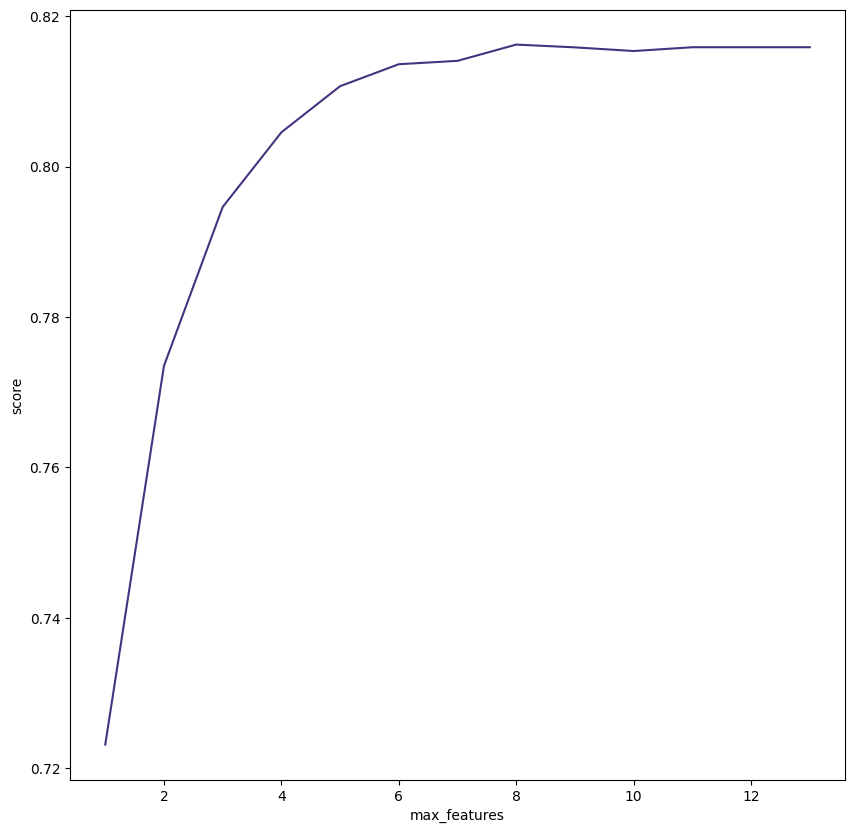

In [53]:
plt.figure(figsize=(10,10))

x_vals = range(1,len(df.columns) + 1)
y_vals = []

for i in x_vals:
  rgr = RandomForestRegressor(
      max_depth=13,
      min_samples_split=18,
      min_samples_leaf=10,
      min_weight_fraction_leaf=8e-4,
      max_features=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('max_features')
plt.ylabel('score')
plt.show()

In [32]:
x_vals[y_vals.index(max(y_vals))]

8

In [54]:
y_vals = []

for i in ['sqrt', 'log2']:
  rgr = RandomForestRegressor(
    max_depth=13,
    min_samples_split=18,
    min_samples_leaf=10,
    min_weight_fraction_leaf=8e-4,
    max_features=i,
    random_state=42
    )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

print(y_vals)

[0.7946152244014728, 0.7946152244014728]


As the number of features increases, the model performance improves significantly at first. After approximately 6-8, the score reaches a plateau. The best results are achieved using 8 features - and I'll go with it.

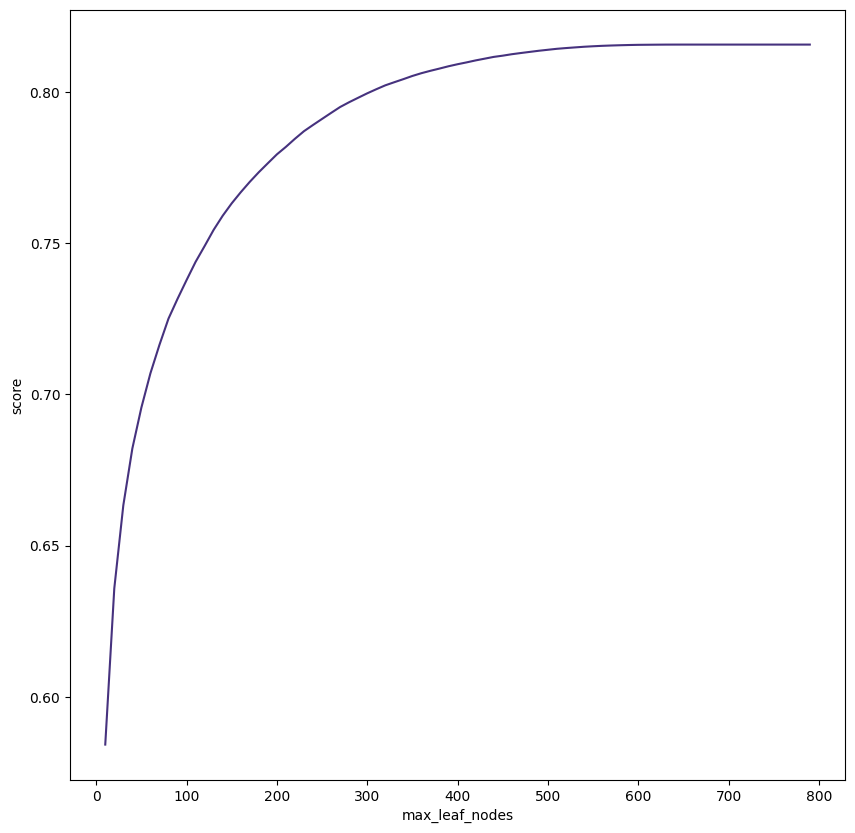

In [55]:
plt.figure(figsize=(10,10))

x_vals = [i * 10 for i in range(1, 80)]
y_vals = []

for i in x_vals:
  rgr = RandomForestRegressor(
      max_depth=13,
      min_samples_split=18,
      min_samples_leaf=10,
      min_weight_fraction_leaf=8e-4,
      max_features=8,
      max_leaf_nodes=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('max_leaf_nodes')
plt.ylabel('score')
plt.show()

In [35]:
x_vals[y_vals.index(max(y_vals))]

650

The max_leaf_nodes parameter controls the maximum number of leaf nodes allowed in the decision tree, directly limiting its complexity. As the number of allowed leaf nodes increases, the model performance improves, indicating that the tree can capture more complex patterns in the data. After approximately 550-600 leaf nodes, the score reaches a plateau, meaning that further increases do not provide significant performance gains. Therefore, 650 is selected as an appropriate value, as it achieves near-maximum performance while avoiding unnecessary model complexity.

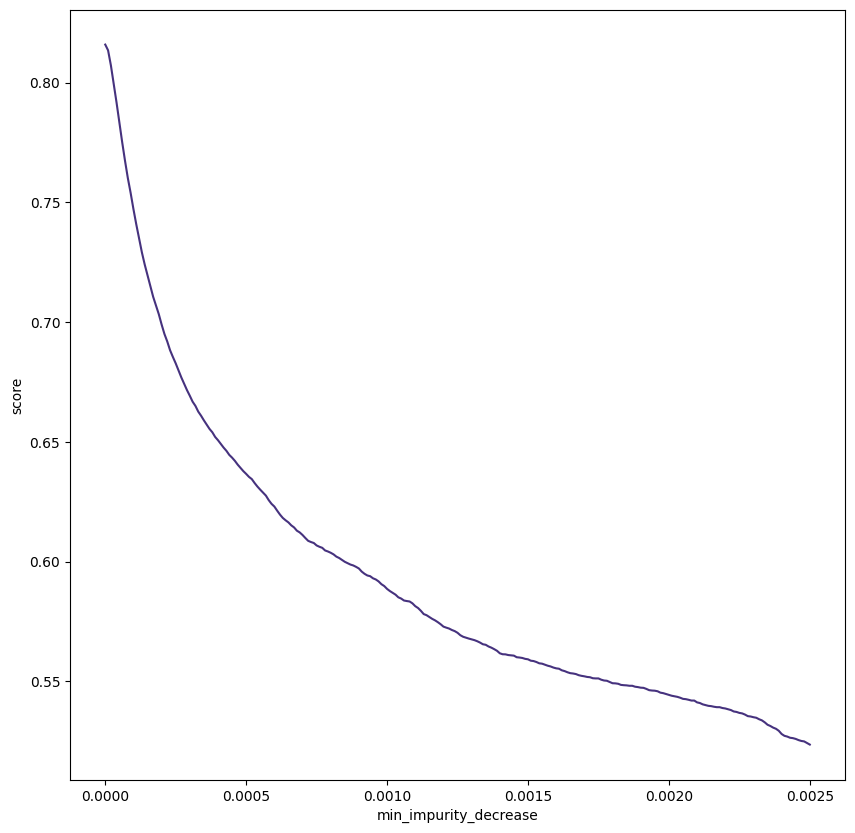

In [36]:
plt.figure(figsize=(10,10))

x_vals = [i * 0.00001 for i in range(0, 251)]
y_vals = []

for i in x_vals:
  rgr = RandomForestRegressor(
      max_depth=13,
      min_samples_split=18,
      min_samples_leaf=10,
      min_weight_fraction_leaf=8e-4,
      max_features=8,
      max_leaf_nodes=650,
      min_impurity_decrease=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('min_impurity_decrease')
plt.ylabel('score')
plt.show()

In [37]:
x_vals[y_vals.index(max(y_vals))]

0.0

A node will be split if this split induces a decrease of the impurity greater than or equal to this value. The best is 0, and we're ok with it.
We won't put it further as its' default is 0.

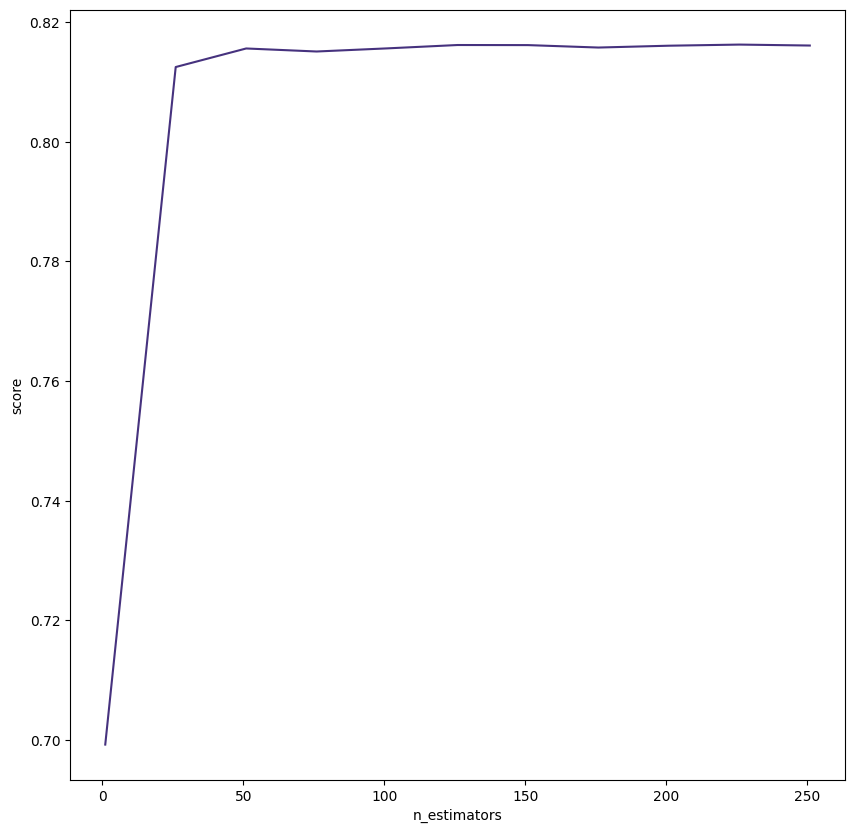

In [11]:
plt.figure(figsize=(10,10))

x_vals = range(1, 252, 25)
y_vals = []

for i in x_vals:
  rgr = RandomForestRegressor(
      max_depth=13,
      min_samples_split=18,
      min_samples_leaf=10,
      min_weight_fraction_leaf=8e-4,
      max_features=8,
      max_leaf_nodes=650,
      n_estimators=i,
      random_state=42
      )
  rgr.fit(X_train, y_train)
  y_vals.append(rgr.score(X_test, y_test))

plt.plot(x_vals, y_vals)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

In [12]:
x_vals[y_vals.index(max(y_vals))]

226

The n_estimators parameter controls the number of DTs in the forest. As we see, the score increases as the n_extimators increases. However, it quickly reaches plateau. So, I'll choose 50.

# **The best model**

In [13]:
rgr = RandomForestRegressor(
    max_depth=13,
    min_samples_split=18,
    min_samples_leaf=10,
    min_weight_fraction_leaf=8e-4,
    max_features=8,
    max_leaf_nodes=650,
    n_estimators=50,
    random_state=42
    )
rgr.fit(X_train, y_train)

rgr.score(X_test, y_test)

0.8151450612994304

This Random Forest is trained with best hyperparameters, which avoids overfitting, and is better than a single DT(0.7564543181694635).